# Convolutional Neural Network

### The SVHN dataset (32-by-32 images)

---

The following notebook contains the source-code for my implementation of a small convolutional neural network on the 32-by-32 images SVHN dataset.

In [7]:
import os
import time
import math
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) # Set default figure size

print("Tensorflow version", tf.__version__)

Tensorflow version 1.8.0


#### Loading the data

Let's load the greyscale images created in ``01-svhn-single-preprocessing.ipynb``

In [8]:
# Open the file as readonly
    h5f = h5py.File('d16129231_data/SVHN_single_grey.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

# Close this file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (598388, 32, 32, 1) (598388, 10)
Validation set (6000, 32, 32, 1) (6000, 10)
Test set (26032, 32, 32, 1) (26032, 10)


#### Data dimensions

In [9]:
# We know that SVHN images have 32 pixels in each dimension
img_size = X_train.shape[1]

# Greyscale images only have 1 color channel
num_channels = X_train.shape[-1]

# Number of classes, one class for each of 10 digits
num_classes = y_train.shape[1]

#### Preprocessing

In [10]:
# Calculate the mean on the training data
train_mean = np.mean(X_train, axis=0)

# Calculate the std on the training data
train_std = np.std(X_train, axis=0)

# Subtract it equally from all splits
X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean)  / train_std
X_val = (train_mean - X_val) / train_std

## Helper functions


### Helper function for plotting images


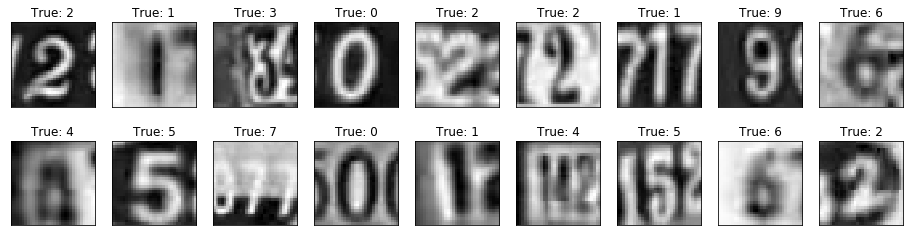

In [11]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Plot nrows * ncols images from images and annotate the images
    """
    # Initialize the subplotgrid
    fig, axes = plt.subplots(nrows, ncols)
    
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        
        # Predictions are not passed
        if cls_pred is None:
            title = "True: {0}".format(np.argmax(cls_true[i]))
        
        # When predictions are passed, display labels + predictions
        else:
            title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), cls_pred[i])  
            
        # Display the image
        ax.imshow(images[i,:,:,0], cmap='binary')
        
        # Annotate the image
        ax.set_title(title)
        
        # Do not overlay a grid
        ax.set_xticks([])
        ax.set_yticks([])
        
        
# Plot 2 rows with 9 images each from the training set
plot_images(X_train, 2, 9, y_train);

### Helper functions for creating new variables


In [12]:
def conv_weight_variable(layer_name, shape):
    """ Retrieve an existing variable with the given layer name 
    """
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())

def fc_weight_variable(layer_name, shape):
    """ Retrieve an existing variable with the given layer name
    """
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    """ Creates a new bias variable
    """
    return tf.Variable(tf.constant(0.0, shape=shape))

### Helper function for stacking CONV-RELU layers followed by an POOL layer


In [13]:
def conv_layer(input,               # The previous layer
                layer_name,         # Layer name
                num_input_channels, # Num. channels in prev. layer
                filter_size,        # Width and height of each filter
                num_filters,        # Number of filters
                pooling=True):      # Use 2x2 max-pooling

    # Shape of the filter-weights for the convolution
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new filters with the given shape
    weights = conv_weight_variable(layer_name, shape=shape)
    
    # Create new biases, one for each filter
    biases = bias_variable(shape=[num_filters])

    # Create the TensorFlow operation for convolution
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME') # with zero padding

    # Add the biases to the results of the convolution
    layer += biases
    
    # Rectified Linear Unit (RELU)
    layer = tf.nn.relu(layer)

    # Down-sample the image resolution
    if pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Return the resulting layer and the filter-weights
    return layer, weights

### Helper function for reshaping the CONV layers to FC layers


In [14]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The number of features is: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, num_features])

    # Return the flattened layer and the number of features.
    return layer_flat, num_features

### Helper function for stacking FC-RELU layers


In [15]:
def fc_layer(input,        # The previous layer
             layer_name,   # The layer name
             num_inputs,   # Num. inputs from prev. layer
             num_outputs,  # Num. outputs
             relu=True):   # Use RELU?

    # Create new weights and biases.
    weights = fc_weight_variable(layer_name, shape=[num_inputs, num_outputs])
    biases = bias_variable(shape=[num_outputs])

    # Calculate the layer activation
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if relu:
        layer = tf.nn.relu(layer)

    return layer

## Tensorflow Model


In [16]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 32         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 64         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 256            # Number of neurons in fully-connected layer.

### Placeholder Variables


In [17]:
x = tf.placeholder(tf.float32, shape=(None, img_size, img_size, num_channels), name='x')

In [18]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


In [19]:
keep_prob = tf.placeholder(tf.float32)

### ConvNet Architecture

``` INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL] -> DROPOUT -> [FC -> RELU] -> FC ```

#### Convolutional Layer 1


In [20]:
conv_1, w_c1 = conv_layer(input=x,
                          layer_name="conv_1",
                          num_input_channels=num_channels,
                          filter_size=filter_size1,
                          num_filters=num_filters1, pooling=True)

conv_1

<tf.Tensor 'MaxPool:0' shape=(?, 16, 16, 32) dtype=float32>

#### Convolutional Layer 2


In [21]:
conv_2, w_c2 = conv_layer(input=conv_1,
                          layer_name="conv_2",
                          num_input_channels=num_filters1,
                          filter_size=filter_size2,
                          num_filters=num_filters2,
                          pooling=True)

# Apply dropout after the pooling operation
dropout = tf.nn.dropout(conv_2, keep_prob)

dropout

<tf.Tensor 'dropout/mul:0' shape=(?, 8, 8, 64) dtype=float32>

#### Flatten Layer


In [22]:
layer_flat, num_features = flatten_layer(dropout)

layer_flat

<tf.Tensor 'Reshape:0' shape=(?, 4096) dtype=float32>

#### Fully-Connected Layer 1

In [23]:
fc_1 = fc_layer(input=layer_flat,
                layer_name="fc_1",
                num_inputs=num_features,
                num_outputs=fc_size,
                relu=True)

fc_1

<tf.Tensor 'Relu_2:0' shape=(?, 256) dtype=float32>

#### Fully-Connected Layer 2

In [24]:
fc_2 = fc_layer(input=fc_1,
                layer_name="fc_2",
                num_inputs=fc_size,
                num_outputs=num_classes,
                relu=False)

fc_2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

#### Predicted Class


In [25]:
y_pred = tf.nn.softmax(fc_2)

# The class-number is the index of the largest element.
y_pred_cls = tf.argmax(y_pred, dimension=1)

### Cost Function


In [26]:
# Calcualte the cross-entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc_2, labels=y_true)

# Take the average of the cross-entropy for all the image classifications.
cost = tf.reduce_mean(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Optimization Method


In [27]:
# Global step is required to compute the decayed learning rate
global_step = tf.Variable(0)

# Apply exponential decay to the learning rate
learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.96, staircase=True)

# Construct a new Adam optimizer
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(cost, global_step=global_step)

### Evaluation Metric


In [28]:
# Predicted class equals the true class of each image?
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

# Cast predictions to float and calculate the mean
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Execution Phase

### Create TensorFlow Session


In [29]:
session = tf.Session()

The variables for weights and biases are initialized.

In [30]:
session.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


### Saver Object

In [31]:
saver = tf.train.Saver()

save_dir = 'checkpoints/'

# Create directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save_path = os.path.join(save_dir, 'svhn_single_greyscale')

#### Restoring a Previous Session

 Uncomment it if variables that were saved to file during previous optimization needs to be re loaded.

In [32]:
#saver.restore(sess=session, save_path=save_path)

### Helper function for executing the learning process


In [33]:
# Number of training samples in each iteration 
batch_size = 64

# Keep probability in dropout layer
dropout = 0.5

In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.

In [40]:
total_iterations = 0
plot_accuracy = []
plot_step = []
plot_valaccuracy = []
def traintest(num_iterations, display_step):
    
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for step in range(num_iterations):

        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :, :, :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        
        feed_dict_train = {x: batch_data, y_true: batch_labels, keep_prob: dropout}

        # Run the optimizer using this batch of training data.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every display_step
        if step % display_step == 0:
            
            # Calculate the accuracy on the training-set.
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)
            plot_accuracy.append(batch_acc)
            plot_step.append(step)
            print("Minibatch accuracy at step %d: %.4f" % (step, batch_acc))
            
            # Calculate the accuracy on the validation-set
            validation_acc = session.run(accuracy, {x: X_val, y_true: y_val, keep_prob: 1.0})
            plot_valaccuracy.append(validation_acc)
            print("Validation accuracy: %.4f" % validation_acc)

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Difference between start and end-times.
    time_diff = time.time() - start_time
    
    # Calculate the accuracy on the test-set
    test_accuracy = session.run(accuracy, {x: X_test, y_true: y_test, keep_prob: 1.0})
    
    print("Test accuracy: %.4f" % test_accuracy)
    print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))
    
   

Minibatch accuracy at step 0: 0.2188
Validation accuracy: 0.1008
Minibatch accuracy at step 50: 0.2969
Validation accuracy: 0.2023
Minibatch accuracy at step 100: 0.5781
Validation accuracy: 0.5198
Minibatch accuracy at step 150: 0.8281
Validation accuracy: 0.6823
Minibatch accuracy at step 200: 0.7656
Validation accuracy: 0.6595
Minibatch accuracy at step 250: 0.9219
Validation accuracy: 0.7425
Minibatch accuracy at step 300: 0.7188
Validation accuracy: 0.7572
Minibatch accuracy at step 350: 0.9219
Validation accuracy: 0.7440
Minibatch accuracy at step 400: 0.9062
Validation accuracy: 0.7892
Minibatch accuracy at step 450: 0.8438
Validation accuracy: 0.7750
Minibatch accuracy at step 500: 0.9062
Validation accuracy: 0.8155
Minibatch accuracy at step 550: 0.9062
Validation accuracy: 0.8218
Minibatch accuracy at step 600: 0.8750
Validation accuracy: 0.8037
Minibatch accuracy at step 650: 0.7500
Validation accuracy: 0.8113
Minibatch accuracy at step 700: 0.9375
Validation accuracy: 0.837

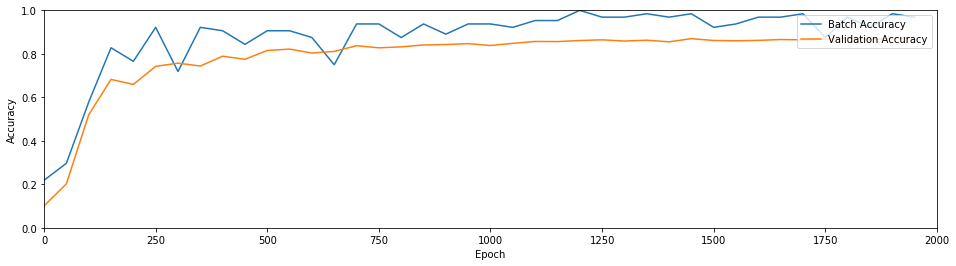

In [35]:
traintest(num_iterations=2000, display_step=50)

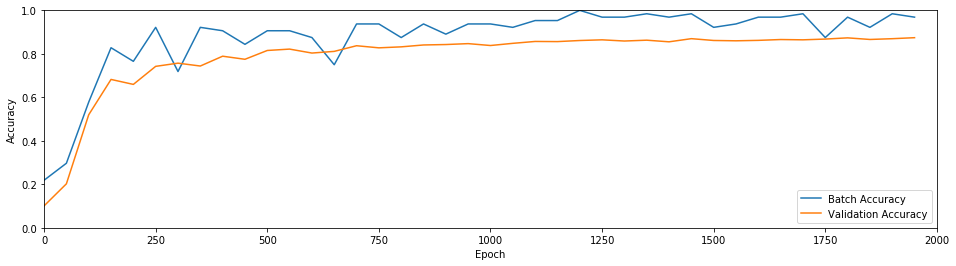

In [37]:
plt.plot(plot_step,plot_accuracy)
plt.plot(plot_step, plot_valaccuracy)
plt.ylim([0,1])
plt.xlim([0,2000])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Batch Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [41]:
traintest(num_iterations=20000, display_step=1000)

Minibatch accuracy at step 0: 0.9531
Validation accuracy: 0.8782
Minibatch accuracy at step 1000: 0.9531
Validation accuracy: 0.8907
Minibatch accuracy at step 2000: 0.9531
Validation accuracy: 0.8937
Minibatch accuracy at step 3000: 0.9844
Validation accuracy: 0.8997
Minibatch accuracy at step 4000: 0.9688
Validation accuracy: 0.9092
Minibatch accuracy at step 5000: 0.9844
Validation accuracy: 0.9032
Minibatch accuracy at step 6000: 1.0000
Validation accuracy: 0.9057
Minibatch accuracy at step 7000: 0.9219
Validation accuracy: 0.9088
Minibatch accuracy at step 8000: 0.9531
Validation accuracy: 0.9108
Minibatch accuracy at step 9000: 1.0000
Validation accuracy: 0.9120
Minibatch accuracy at step 10000: 0.9375
Validation accuracy: 0.9117
Minibatch accuracy at step 11000: 0.9688
Validation accuracy: 0.9173
Minibatch accuracy at step 12000: 0.9844
Validation accuracy: 0.9168
Minibatch accuracy at step 13000: 0.9688
Validation accuracy: 0.9185
Minibatch accuracy at step 14000: 0.9688
Valida

 Let's save all variables of the TensorFlow graph to file.

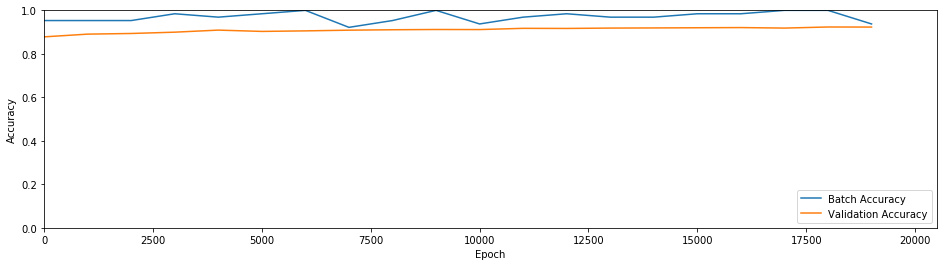

In [42]:
 # Visualize Accuracy over Epochs 
plt.plot(plot_step,plot_accuracy)
plt.plot(plot_step, plot_valaccuracy)
plt.ylim([0,1])
plt.xlim([0,20500])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Batch Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [43]:
saver.save(sess=session, save_path=save_path)

'checkpoints/svhn_single_greyscale'

### Model evaluation

In [44]:
# Generate predictions for the testset
test_pred = session.run(y_pred_cls, {x: X_test, y_true: y_test, keep_prob: 1.0})

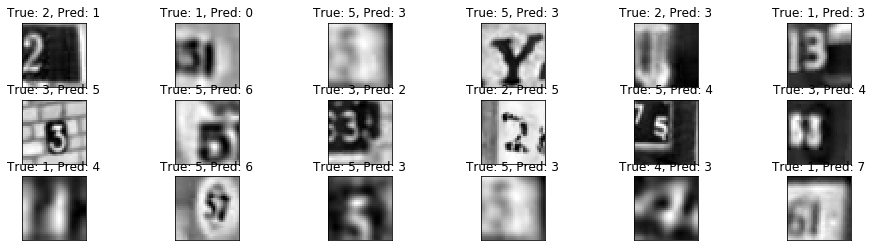

In [45]:
# Find the incorrectly classified examples
incorrect = test_pred != np.argmax(y_test, axis=1)

# Select the incorrectly classified examples
images = X_test[incorrect]
cls_true = y_test[incorrect]
cls_pred = test_pred[incorrect]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred);

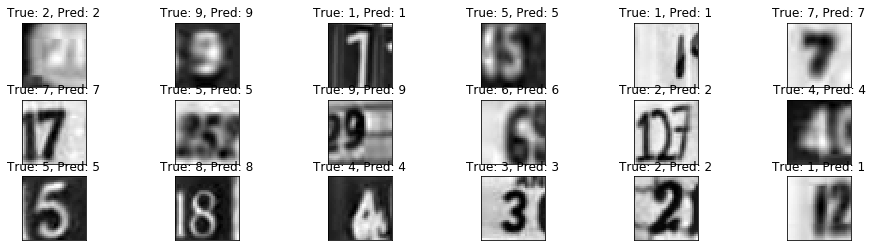

In [46]:
# Find the incorrectly classified examples
correct = np.invert(incorrect)

# Select the correctly classified examples
images = X_test[correct]
cls_true = y_test[correct]
cls_pred = test_pred[correct]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred);

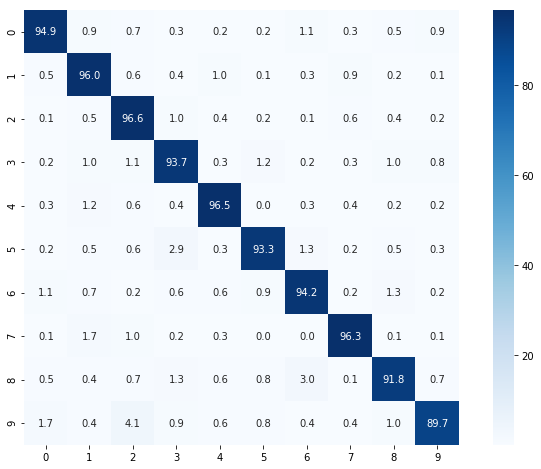

In [48]:
from sklearn.metrics import confusion_matrix

# Set the figure size
plt.figure(figsize=(12, 8))

# Calculate the confusion matrix
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=test_pred)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.1f', square=True);